In [2]:
import nltk 
import pandas as pd
import re


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
df = pd.read_csv('datasets/gcc_bug_report_data.csv', encoding='utf8', sep=',', parse_dates=True,low_memory=False)

In [4]:
df['long_lived?']  = df['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')


In [5]:
df.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived?
0,CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font...,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2,short-lived
1,GCC-43111,2010-02-18,fortran,GCC,[4.5 Regression] No temporary produced for arr...,As reported by Joost VandeVondele this does no...,pault,pault,fixed,1,resolved,4,2010-02-20,0,6,2010-02-20,2,normal,2,short-lived
2,GCC-43804,2010-04-19,target,GCC,[4.6 regression] ICE in reload_cse_simplify_op...,$ gcc/xgcc -Bgcc/ -O2 -fpic -S memusage.i \nme...,rsandifo,schwab,fixed,1,resolved,4,2013-04-12,0,29,2013-04-12,1089,normal,2,long-lived
3,GCC-33988,2007-11-03,ada,GCC,Warning when converting between C compatible p...,The RM95 B.3.1 contains: The type chars_ptr is...,unassigned,sam,fixed,1,resolved,4,2007-12-05,0,3,2007-11-14,11,normal,2,short-lived
4,GCC-56270,2013-02-09,tree-optimization,GCC,[4.6 Regression] loop over array of struct flo...,Created attachment 29408\nPreprocessed file co...,rguenth,4303843KIWEMNPULN,fixed,1,resolved,4,2013-04-12,0,11,2013-04-12,62,normal,2,short-lived


In [6]:
df['long_lived?'].value_counts()

short-lived    7085
long-lived     2915
Name: long_lived?, dtype: int64

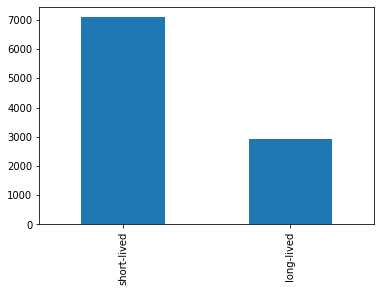

In [7]:
df['long_lived?'].value_counts().sort_values(ascending=False).plot(kind='bar', title='')

In [8]:
def print_plot(index):
    example=df.loc[df.index == index][['long_description', 'long_lived?']].values[0]
    if(len (example) > 0):
        print(example[0])
        print('long_lived?', example[1])

In [9]:
print_plot(1)

As reported by Joost VandeVondele this does not compile correctly since my fix for PR41113/7

Paul

SUBROUTINE S2(I)
 INTEGER :: I(4)
 write(6*) I
 IF (ANY(I.NE.(/3579/))) CALL ABORT()
END SUBROUTINE S2

MODULE M1
 TYPE T1
  INTEGER POINTER DIMENSION(:) :: data
 END TYPE T1
CONTAINS
 SUBROUTINE S1()
   TYPE(T1) :: d
   INTEGER TARGET DIMENSION(10) :: scratch=(/(ii=110)/)
   INTEGER :: i=2
   d%data=>scratch(1:9:2)
   write(6*) d%data(i:)
   CALL S2(d%data(i:))
 END SUBROUTINE S1
END MODULE M1

USE M1
CALL S1
END
long_lived? short-lived


In [10]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    if text != text:
        return ' '
    
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['long_description'] = df['long_description'].apply(clean_text)
df['long_description'] = df['long_description'].str.replace('\d+', '')

In [11]:
print_plot(1)

reported joost vandevondele compile correctly since fi pr paulsubroutine s integer  write  ine  call abort end subroutine smodule m type t integer pointer dimension data end type tcontains subroutine s type t integer target dimension  scratch ii integer i ddatascratch  write  ddata call s ddata end subroutine send module muse mcall send
long_lived? short-lived


In [12]:
MAX_NB_WORDS        = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM       = 100

# Vectorize a text corpus, by turning each text into sequence of integers
# (each integer being index of a token dictionary) or into a vector where
# the coefficient for each token could be binary, based on word count, base 
# on tf-idf
#
# Arguments:
#    
#    num_words: the maximum number of words to keep, based on word frequency. 
#    filters  : a string where each element is a character that will be filtered from the texts.
#    lower    : boolean. Whether to convert to texts to lowercase.
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)


# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency.
tokenizer.fit_on_texts(df['long_description'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 148064 unique tokens.


In [13]:
# Transforms each text in texts to a sequence of integers.
X = tokenizer.texts_to_sequences(df['long_description'].values)

print(X)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
Y = pd.get_dummies(df['long_lived?']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 2)


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(9000, 250) (9000, 2)
(1000, 250) (1000, 2)


In [15]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

epochs     = 5
batch_size = 64
history    = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8100 samples, validate on 900 samples
Epoch 1/5





8100/8100 [==============================] - 59s 7ms/step - loss: 0.5815 - binary_accuracy: 0.7137 - val_loss: 0.5243 - val_binary_accuracy: 0.7689
Epoch 2/5
8100/8100 [==============================] - 55s 7ms/step - loss: 0.4332 - binary_accuracy: 0.8096 - val_loss: 0.5447 - val_binary_accuracy: 0.7444
Epoch 3/5
8100/8100 [==============================] - 60s 7ms/step - loss: 0.2909 - binary_accuracy: 0.8817 - val_loss: 0.6805 - val_binary_accuracy: 0.7222
Epoch 4/5
8100/8100 [==============================] - 56s 7ms/step - loss: 0.1768 - binary_accuracy: 0.9351 - val_loss: 0.8525 - val_binary_accuracy: 0.7111


In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1000/1000 [==============================] - 2s 2ms/step
Test set
  Loss: 0.842
  Accuracy: 0.720


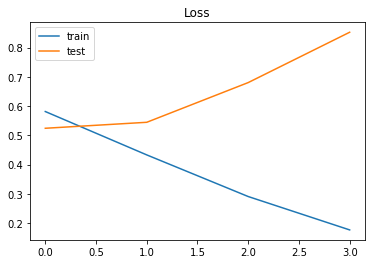

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

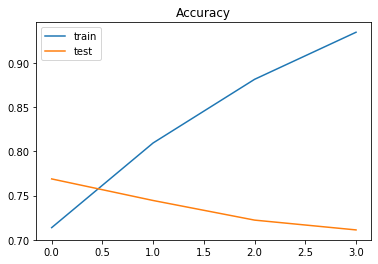

In [18]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.show();